# Piepelines and Grid Search Practice:
# Finding the Best Pipeline for Malware Classification

The dataset I will be working with records permissions for Android apps and their status as malware or benevolent. It can be found at https://archive-beta.ics.uci.edu/api/static/ml/datasets/722/data.csv and was collected to be the basis of a paper on malware classification (Mathur, Akshay, et al. "NATICUSdroid: A malware detection framework for Android using native and custom permissions." Journal of Information Security and Applications 58 (2021): 102696.) The dataset is, unsurprisingly, very well suited and prepared for comparing the performance of different classification models, since that is part of what Akshay et. al. are doing as well. Here this will only happen on a toy scale of course, most importantly, I have tried to keep the runtime of this notebook in check, since grid searches can take a lot of time, especially with sophisticated models, promising candidates are often not included (e.g. GBMs).
The plan is to compare pipelines with three different kinds of model, K Nearest Neighbors, Logistic Regression and Random Forest, with scaling and feature selection as data preparation steps. The best parameters for each pipeline will be found through grid search and then the three winners will compete on the test data. 

## Setting Up

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

In [5]:
df = pd.read_csv("data/data.csv")

## A Quick Look at the Dataset

In [6]:
df.head()

,android.permission.GET_ACCOUNTS,com.sonyericsson.home.permission.BROADCAST_BADGE,android.permission.READ_PROFILE,android.permission.MANAGE_ACCOUNTS,android.permission.WRITE_SYNC_SETTINGS,android.permission.READ_EXTERNAL_STORAGE,android.permission.RECEIVE_SMS,com.android.launcher.permission.READ_SETTINGS,android.permission.WRITE_SETTINGS,com.google.android.providers.gsf.permission.READ_GSERVICES,...,com.android.launcher.permission.UNINSTALL_SHORTCUT,com.sec.android.iap.permission.BILLING,com.htc.launcher.permission.UPDATE_SHORTCUT,com.sec.android.provider.badge.permission.WRITE,android.permission.ACCESS_NETWORK_STATE,com.google.android.finsky.permission.BIND_GET_INSTALL_REFERRER_SERVICE,com.huawei.android.launcher.permission.READ_SETTINGS,android.permission.READ_SMS,android.permission.PROCESS_INCOMING_CALLS,Result
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


The data is all binary, with 86 columns representing different Andriod app permissions and one "Result" column that tells us whether the app represented by the row is malware or not. 

In [7]:
df.shape

(29332, 87)

There are almost 30000 apps in the dataset.
I deleted the info() call to check for null values here (those 87 columns make for a long printout), there aren't any. 

In [8]:
df.Result.mean()

0.5011591435974363

About half of the apps in the dataset are malware.

In [9]:
df.mean().sort_values()

android.permission.android.permission.READ_PHONE_STATE    0.003614
android.permission.PROCESS_INCOMING_CALLS                 0.003648
android.permission.FOREGROUND_SERVICE                     0.003887
com.sec.android.iap.permission.BILLING                    0.003887
com.amazon.device.messaging.permission.RECEIVE            0.003921
                                                            ...   
android.permission.ACCESS_WIFI_STATE                      0.525058
android.permission.READ_PHONE_STATE                       0.587379
android.permission.WRITE_EXTERNAL_STORAGE                 0.669201
android.permission.ACCESS_NETWORK_STATE                   0.949032
android.permission.INTERNET                               0.975317
Length: 87, dtype: float64

Here we can see the proportion of apps that request certain permissions, some are extremely widespread - over 97% of apps want internet - some are as rare as 0.3%. There aren't many permissions that are overwhelmingly popular, by the fourth most common one we are already under 60%.

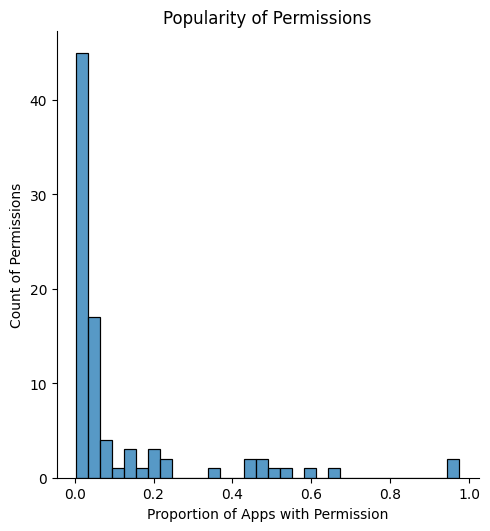

In [10]:
sns.displot(df.mean())
plt.title("Popularity of Permissions")
plt.ylabel("Count of Permissions")
plt.xlabel("Proportion of Apps with Permission")
plt.show()

In fact, most permissions are quite unpopular, over half are present in less than 5% of apps.

In [11]:
df.iloc[:, :-1].sum(axis=1).sort_values()

0         0
10086     0
12762     0
4290      0
15484     0
         ..
2029     55
11212    56
4507     56
12460    56
13110    65
Length: 29332, dtype: int64

Here we can see how many permissions each app contains, 65 being the highest number, interestingly, sometimes the number is 0. This is due to the methods employed in collecting the dataset, permissions present in fewer than 100 apps were excluded, leading to some apps with only rare permissions to have none left.
Let's have a look at the difference between malware and benevolent apps. 

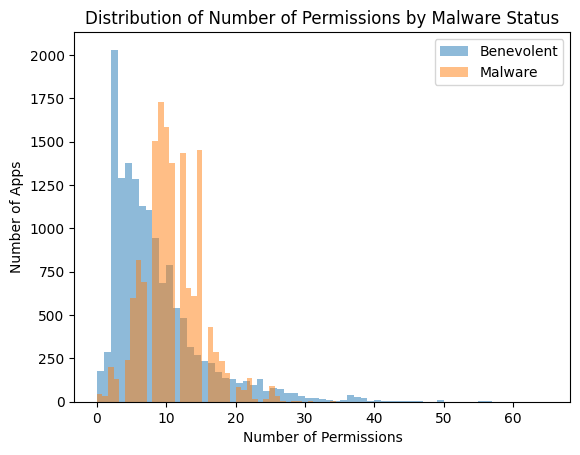

In [12]:
plt.hist(df[df.Result == 0].sum(axis=1), alpha=0.5, bins=65, label="Benevolent")
plt.hist(df[df.Result == 1].sum(axis=1).apply(lambda x: x - 1), alpha=0.5, bins=65, label="Malware")
plt.title("Distribution of Number of Permissions by Malware Status")
plt.xlabel("Number of Permissions")
plt.ylabel("Number of Apps")
plt.legend()
plt.show()

Unsurprisingly, malware tends to request more permissions.
But what about specific permission?

In [13]:
contrast = df.groupby("Result").mean().transpose()
contrast["difference"] = abs(contrast.iloc[:,0] - contrast.iloc[:,1])
contrast.sort_values(by="difference", ascending=False).head(10)

Result,0,1,difference
android.permission.READ_PHONE_STATE,0.229975,0.943129,0.713154
android.permission.RECEIVE_BOOT_COMPLETED,0.205919,0.702653,0.496735
android.permission.ACCESS_COARSE_LOCATION,0.248360,0.678435,0.430076
android.permission.ACCESS_FINE_LOCATION,0.242072,0.648027,0.405955
com.google.android.c2dm.permission.RECEIVE,0.411700,0.014082,0.397619
com.android.launcher.permission.INSTALL_SHORTCUT,0.028636,0.398844,0.370208
android.permission.GET_TASKS,0.068617,0.397687,0.329070
android.permission.SYSTEM_ALERT_WINDOW,0.058570,0.314762,0.256192
android.permission.ACCESS_WIFI_STATE,0.419970,0.629660,0.209690
com.android.vending.BILLING,0.219245,0.046395,0.172851


Here I have calculated the difference between the proportions in which permissions are present in benign and malware apps and displayed the most extreme cases. We can see that there are indeed some permissions where the difference is huge, about 95% of malware really wants to know about our phone state, while only about 23% of benign apps are that curious.

## The Pipelines

Now that we have gotten a quick overview of the dataset, we can separate it into features and labels...

In [14]:
features = df.iloc[:, :-1]
print(features.shape)
labels = df.iloc[:, -1]
print(labels.shape)

(29332, 86)
(29332,)


...and into training and test data.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=42)

### K Nearest Neighbors

It is time to define the first pipeline. It is possible to define just one pipeline and have GridSearchCV() try several estimators from a list, but since I would like to have a look at the best models from each category, there will be one pipeline for each classifier, starting with K Nearest Neighbors. For feature selection SelectKBest() will be used and before that, we optionally scale with StandardScaler(). Why scale binary data? Well, honestly because the feature selection performs pretty badly and I didn't want to have a half useless two-step pipeline, that's just a model! So, since one of the advantages of grid searching for the best pipeline is that one can try some non-intuitive options, scaling got a shot and actually worked, as we will see soon. 

In [16]:
pipe_knn = Pipeline([
("scaler", StandardScaler()),
("selector", SelectKBest()),
("classifier", KNeighborsClassifier())
])

Next the parameter grid for the grid search has to be defined. The options for StandardScaler() are simply to employ it or skip the scaling step. For SelectKBest() the scoring functions to be tried will be the ANOVA f-value based f_classif() and chi2(), although the latter does not play nice with negative values, which we will have after scaling. It will still give us results for the unscaled cases and using mutual information instead is just too slow. The number of features selected will be varied (including selecting all features). The classifier will run with different numbers of neighbors and with a uniform and non-uniform weighting of neighbors. Of course, more variations would make sense, but this will already take a while to run. The lists for numbers of features and neighbors have been narrowed down after test runs with more options, that will typically be the case throughout this section.  

In [17]:
parameters_knn = {
    "scaler": ["passthrough", StandardScaler()],
	"selector__score_func": [f_classif, chi2],
    "selector__k": [50, 70, "all"],
	"classifier__n_neighbors": [5, 7, 10, 13],
	"classifier__weights": ["uniform", "distance"]
     }

Now the grid search can start, the cross valuation parameter will be set to 4, a higher value and maybe a repeated cross valuation would be more appropiate, but, again, that would make this notebook run for an extremely long time. The pipelines will be scored on accuracy.

In [18]:
grid_knn = GridSearchCV(pipe_knn, parameters_knn, cv=4, scoring="accuracy", n_jobs=-1).fit(X_train, y_train)

/Users/doro/.pyenv/versions/3.9.8/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
96 fits failed out of a total of 384.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
96 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/doro/.pyenv/versions/3.9.8/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/doro/.pyenv/versions/3.9.8/lib/python3.9/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/doro/.pyenv/versions/3.9.8/lib/python3.9/site-packages/sklearn/pipeline.py", line 336, in _fit
    X, 

Let's take a look at the best combination of parameters grid search has come up with.

In [19]:
print(grid_knn.best_score_, grid_knn.best_params_)

0.9634529253252657 {'classifier__n_neighbors': 10, 'classifier__weights': 'distance', 'scaler': 'passthrough', 'selector__k': 'all', 'selector__score_func': <function f_classif at 0x17daaed30>}


The best pipeline has an average accuracy of 96.3%, uses 10 neighbors, no feature selection, no scaling and weights neighbors by distance.

The average accuracy scores over the folds (and plenty of other information) are stored in a dictionary accessible via the grid object method cv_results_(). In order to visualize them, they will first be transformed into a data frame.

In [20]:
result_df_knn = pd.DataFrame.from_dict(grid_knn.cv_results_, orient="columns")

First, two plots of mean accuracy score against number of neighbors, one for each weights setting, with the color of the lines representing amount of retained features.

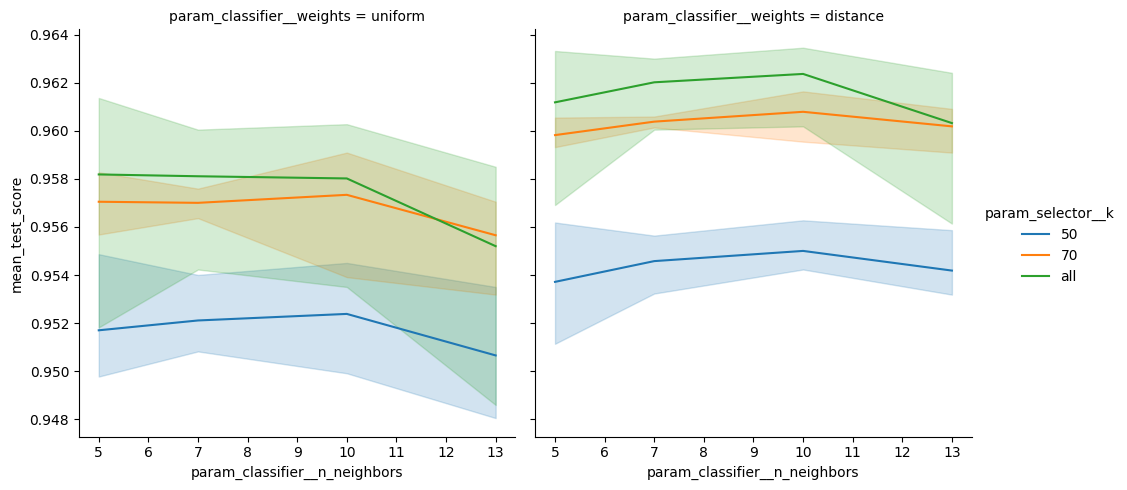

In [21]:
sns.relplot(data=result_df_knn,
            kind="line",
            x="param_classifier__n_neighbors",
            y="mean_test_score",
            hue="param_selector__k",
            col="param_classifier__weights")
plt.show()

We can see that 10 neighbors with weights set to distance performs slightly better than 5, while in the uniform case, accuracy decays for n_neighbors over 5 (and is generally worse). Feature selection is detrimental throughout.

In the next two plots, the color represents the scoring function for feature selection. The side by side plots are with and without scaling.

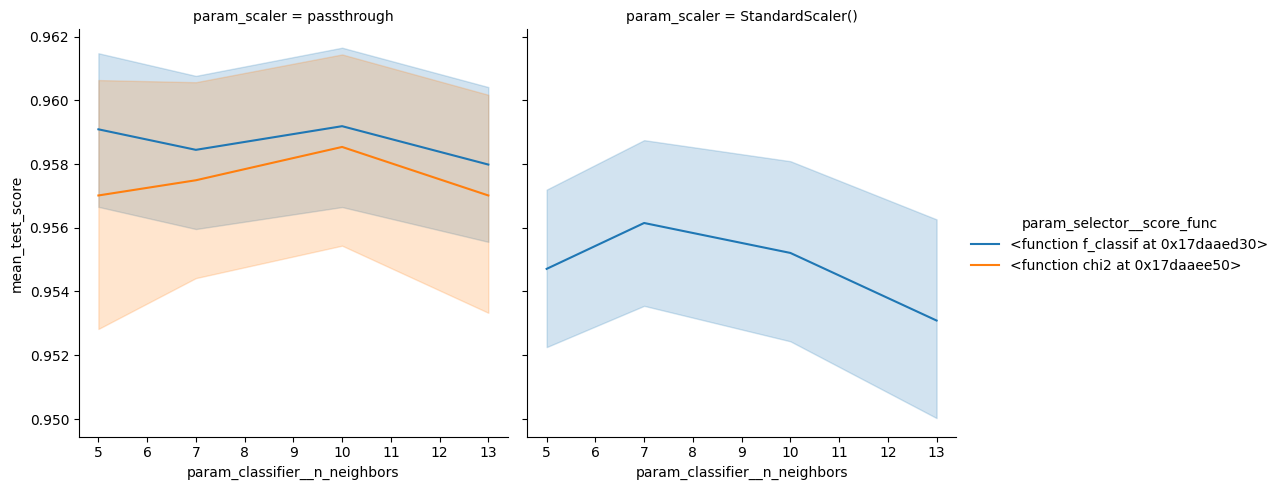

In [22]:
sns.relplot(data=result_df_knn,
	kind="line",
	x="param_classifier__n_neighbors",
	y="mean_test_score",
	hue="param_selector__score_func",
	col="param_scaler")
plt.show()

Here two things are clearly visible. First, as expected, we are not getting results from the chi2 function for scaled data, it does slightly worse on non-scaled. But then, in the best performing case of no feature restriction it, obviously, doesn't matter how features are scored. Unless restricted features take the lead in combination with one of the following classifiers, which I doubt, we won't have to look at this comparison again. Second, scaling did very badly in this combination.

### Logistic Regression

For the Logistic Regression parameter grid, the settings for scaling and selection remain the same. Regarding the classifier the grid search will go through several options for solvers, penalty type and penalty strength. We will get some non-results again, since the newton-cg solver is not compatible with an l1 penalty. The specific options were again narrowed down from more extensive lists through test runs. 

In [23]:
pipe_lr = Pipeline([
("scaler", StandardScaler()),
("selector", SelectKBest()),
("classifier", LogisticRegression())
])
parameters_lr = {
	"scaler": ["passthrough", StandardScaler()],
    "selector__score_func": [f_classif, chi2],
    "selector__k": [50, 70, "all"],
	"classifier__solver": ["newton-cg", "liblinear"],
    "classifier__penalty": ["l1", "l2"],
    "classifier__C": [0.1, 1.0, 10],
    "classifier__random_state": [42]
     }
grid_lr = GridSearchCV(pipe_lr, parameters_lr, cv=4, scoring="accuracy", n_jobs=-1).fit(X_train, y_train)
print(grid_lr.best_score_, grid_lr.best_params_)

/Users/doro/.pyenv/versions/3.9.8/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
252 fits failed out of a total of 576.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/doro/.pyenv/versions/3.9.8/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/doro/.pyenv/versions/3.9.8/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/doro/.pyenv/versions/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logisti

0.9598617930532825 {'classifier__C': 1.0, 'classifier__penalty': 'l1', 'classifier__random_state': 42, 'classifier__solver': 'liblinear', 'scaler': StandardScaler(), 'selector__k': 'all', 'selector__score_func': <function f_classif at 0x17daaed30>}


Average accuracy of the best pipeline rounds to 96%, so 0.3% down from the KNN result. Its classifier uses a penalty of type l1 with a strength of 1.0 and employs the liblinear solver. It uses scaling, but no feature selection.

The following two plots depict the different penalty types, the axes are penalty strength and mean accuracy, with color representing the solver.

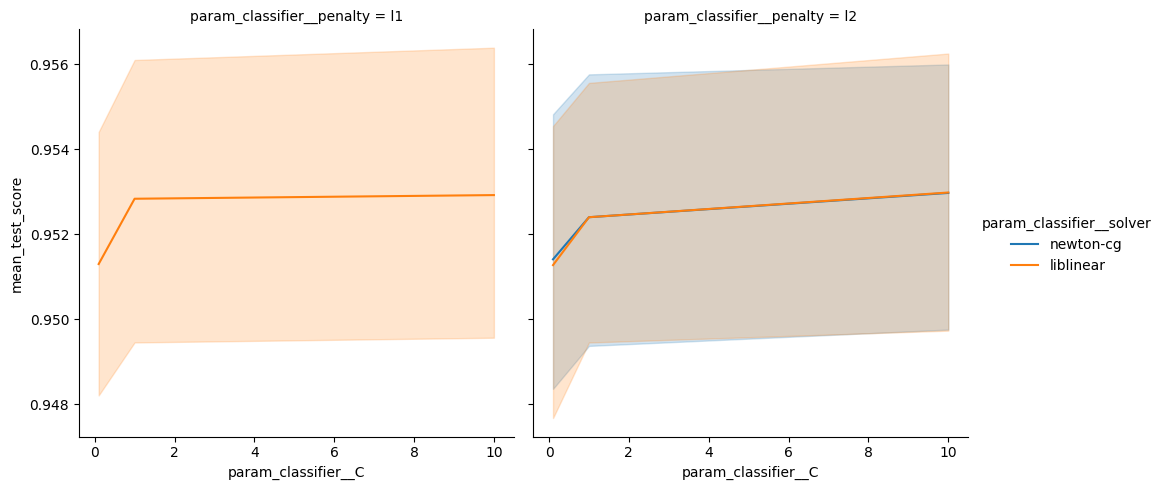

In [24]:
result_df_lr = pd.DataFrame.from_dict(grid_lr.cv_results_, orient="columns")
sns.relplot(data=result_df_lr,
            kind="line",
            x="param_classifier__C",
            y="mean_test_score",
            hue="param_classifier__solver",
            col="param_classifier__penalty")
plt.show()

While the l2 penalty increases up to penalty strength 10, it does not quite reach the peak of the l1 penalty at strength 1. While I have checked some higher values and l2 falls off soon, in a more serious setting it would be worth it to run a search through some values slightly larger than 10 and also slightly larger than 1 for potential better performance on the l2 and l1 side respectively. (To reiterate, the newton-cg solver cannot employ an l1 penalty, so it yields no results on the left).

The next plots show the comparison between the presence and absence of scaling.

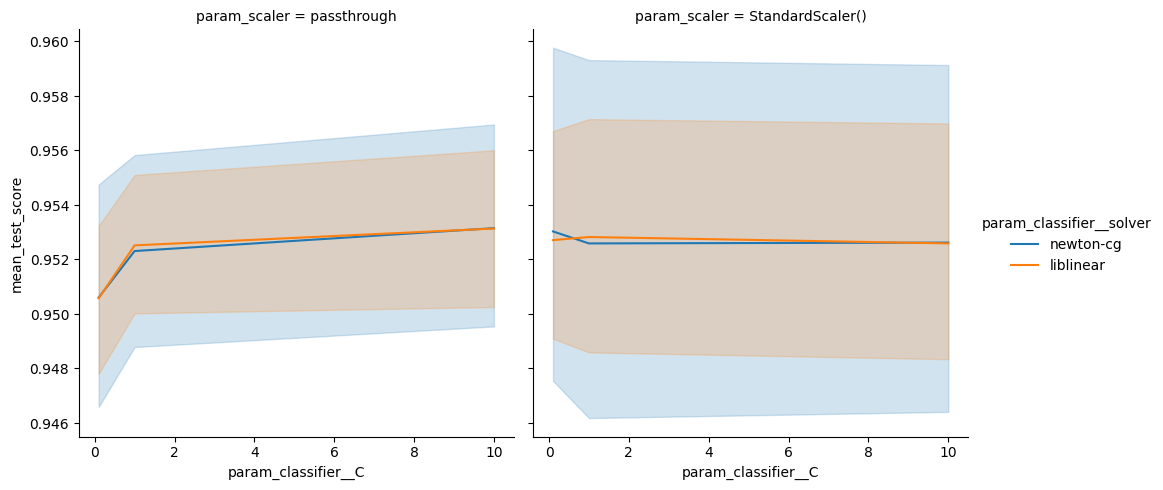

In [25]:
sns.relplot(data=result_df_lr,
            kind="line",
            x="param_classifier__C",
            y="mean_test_score",
            hue="param_classifier__solver",
            col="param_scaler"
            )
plt.show()

Close to no difference between the averages, but the scaling, at a first glance, seems to produce results with a higher variance, verifying that would need a closer look at the results though, the confidence interval estimate in seaborn can be misleading.

### Random Forest

In [26]:
pipe_rf = Pipeline([
("scaler", StandardScaler()),
("selector", SelectKBest()),
("classifier", RandomForestClassifier())
])
parameters_rf = {
    "scaler": ["passthrough", StandardScaler()],
	"selector__score_func": [f_classif, chi2],
    "selector__k": [50, 70, "all"],
	"classifier__max_features": ['sqrt', 'log2'],
	"classifier__n_estimators": [10, 100, 500],
    "classifier__random_state": [42]
     }
grid_rf = GridSearchCV(pipe_rf, parameters_rf, cv=4, scoring="accuracy", n_jobs=-1).fit(X_train, y_train)
print(grid_rf.best_score_, grid_rf.best_params_)

/Users/doro/.pyenv/versions/3.9.8/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
72 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/doro/.pyenv/versions/3.9.8/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/doro/.pyenv/versions/3.9.8/lib/python3.9/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/doro/.pyenv/versions/3.9.8/lib/python3.9/site-packages/sklearn/pipeline.py", line 336, in _fit
    X, 

0.969680470829407 {'classifier__max_features': 'log2', 'classifier__n_estimators': 100, 'classifier__random_state': 42, 'scaler': 'passthrough', 'selector__k': 'all', 'selector__score_func': <function f_classif at 0x17daaed30>}


The mean accuracy of the Random Forest pipeline rounds to 97% (0.7% above KNN, 1% above Logistic Regression), the best result so far. The best pipeline uses no scaling, no feature selection, 100 trees and takes only up to log2 of the full amount of features into account when splitting. It is not strictly speaking the best pipeline, it wins by random tiebreaker against two others, as can be seen in the table below.

In [28]:
result_df_rf = pd.DataFrame.from_dict(grid_rf.cv_results_, orient="columns")
best_couple = result_df_rf.sort_values("rank_test_score").head()
print(best_couple)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
53       2.919721      0.022938         0.303845        0.010607   
52       2.988840      0.074791         0.282012        0.034181   
58       3.032172      0.039308         0.298243        0.043144   
65      14.414192      0.120937         1.472074        0.017370   
64      14.335578      0.113568         1.435170        0.051344   

   param_classifier__max_features param_classifier__n_estimators  \
53                           log2                            100   
52                           log2                            100   
58                           log2                            100   
65                           log2                            500   
64                           log2                            500   

   param_classifier__random_state      param_scaler param_selector__k  \
53                             42       passthrough               all   
52                             42   

Now two plots for non-scaled and scaled cases.

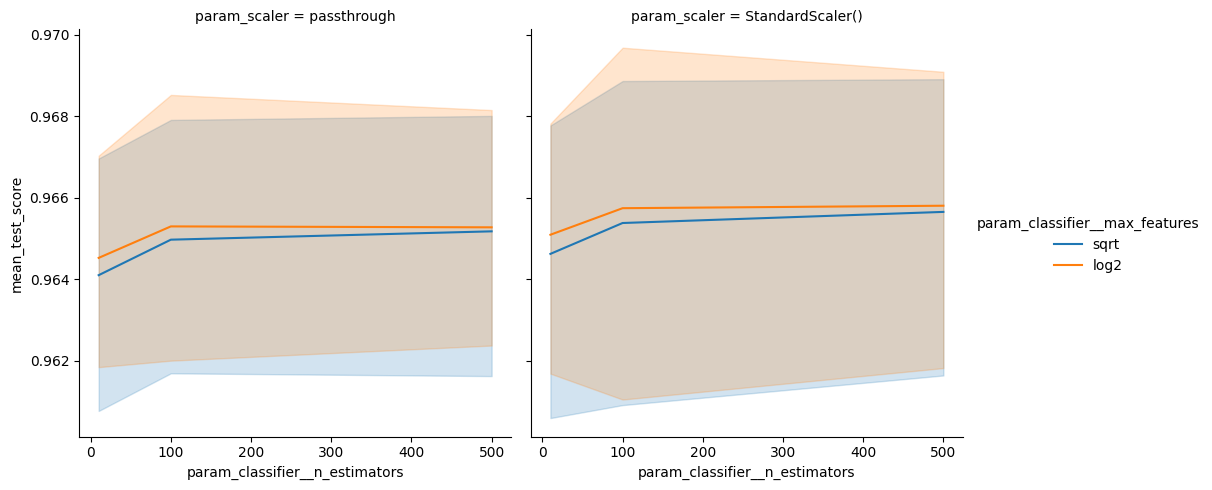

In [29]:
result_df_rf = pd.DataFrame.from_dict(grid_rf.cv_results_, orient="columns")
sns.relplot(data=result_df_rf,
            kind="line",
            x="param_classifier__n_estimators",
            y="mean_test_score",
            hue="param_classifier__max_features",
            col="param_scaler")
plt.show()

Speaking of confidence intervals in seaborn lineplots sometimes being misleading, here we have exactly that: the scaler doesn't reach better results (although also not clearly worse ones) as we saw in the last table. Limiting to the log2 of features comes out slightly ahead of using the square root. The results suggest that it would make sense to further test values for the number of trees between 100 and 500.

## The Final Showdown

Now we have found the best pipelines for each type of classifier, all that is left to do is to see how they do on the test data. The Random Forest had the best score so far, let's see if that will hold up.

KNN did best with no data preparation methods, so no need to put it into a pipeline. Same goes for the Random Forest.

In [30]:
knn = KNeighborsClassifier(n_neighbors=10, weights="distance")
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.96618028092186


In [31]:
logreg = make_pipeline(StandardScaler(), LogisticRegression(C=1.0, penalty="l1", solver="liblinear", random_state=42))
logreg.fit(X_train, y_train)
print(logreg.score(X_test, y_test))

0.963180144552025


In [32]:
rf = RandomForestClassifier(n_estimators=100, max_features="log2", random_state=42)
rf.fit(X_train, y_train)
print(rf.score(X_test, y_test))

0.9721805536615301


The Random Forest is still ahead and all setups beat their average performance in the grid search. It would, of course, make sense to compare more metrics, e.g. F1 Scores or confusion matrices to see to what extent we are getting false positives or false negatives here, but this is already really long, so I will stop here for now.